In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [200]:
tfrecords_base_dir = '../../../../datasets/BDD100k'
BATCH_SIZE = 1
INPUT_SHAPE = 512

In [201]:
@tf.function
def flip_data(image, boxes, w):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack([
            w - boxes[:, 2],
            boxes[:, 1],
            w - boxes[:, 0],
            boxes[:, 3]
        ], axis=-1)
    return image, boxes

def imshow(image):
    plt.figure(figsize=(16, 9))
    plt.axis('off')
    plt.imshow(image)
    
    
def draw_boxes_cv2(image, bbox_list, model_input_shape=INPUT_SHAPE):
    img = np.uint8(image).copy()
    bbox_list = np.array(bbox_list, dtype=np.int32)
    h, w = img.shape[:2]
    h_scale, w_scale = h / model_input_shape, w / model_input_shape
    bbox_list = np.int32(bbox_list * np.array([w_scale, h_scale] * 2))
    for box in bbox_list:
        img = cv2.rectangle(img, (box[0], box[1]),
                            (box[2], box[3]), [30, 15, 200], 1)
    return img

def get_centers(model_input_size=INPUT_SHAPE):
    centers_list = []
    for i in range(3, 8):
        stride = 2**i
        feature_size = np.ceil(model_input_size / stride)

        rx = (np.arange(feature_size) + 0.5) * (stride)
        ry = (np.arange(feature_size) + 0.5) * (stride)
        sx, sy = np.meshgrid(rx, ry)
        cxy = np.stack([sx, sy], axis=-1)
        centers_list.append(cxy)
    return centers_list

In [202]:
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'xmins': tf.io.VarLenFeature(tf.float32),
    'ymins': tf.io.VarLenFeature(tf.float32),
    'xmaxs': tf.io.VarLenFeature(tf.float32),
    'ymaxs': tf.io.VarLenFeature(tf.float32),
    'labels': tf.io.VarLenFeature(tf.float32)
}

@tf.function
def parse_example(example_proto):
    parsed_example = tf.io.parse_single_example(
        example_proto, feature_description)
    image = tf.image.decode_jpeg(parsed_example['image'], channels=3)
    bboxes = tf.stack([
        tf.sparse.to_dense(parsed_example['xmins']),
        tf.sparse.to_dense(parsed_example['ymins']),
        tf.sparse.to_dense(parsed_example['xmaxs']),
        tf.sparse.to_dense(parsed_example['ymaxs'])
    ], axis=-1)
    class_ids = tf.reshape(tf.sparse.to_dense(
        parsed_example['labels']), [-1, 1])
    return image, bboxes, class_ids

def load_data(input_shape):
    h, w = input_shape, input_shape

    @tf.function
    def load_data_(example_proto, input_shape=input_shape):
        image, boxes_, class_ids = parse_example(example_proto)
        image = tf.image.resize(image, size=[h, w])
        boxes = tf.stack([
            tf.clip_by_value(boxes_[:, 0] * w, 0, w),
            tf.clip_by_value(boxes_[:, 1] * h, 0, h),
            tf.clip_by_value(boxes_[:, 2] * w, 0, w),
            tf.clip_by_value(boxes_[:, 3] * h, 0, h)
        ], axis=-1)
        image, boxes = flip_data(image, boxes, w)
        label = tf.concat([boxes, class_ids], axis=-1)
        return image, label
    return load_data_

train_files = tf.data.Dataset.list_files('{}/train*'.format(tfrecords_base_dir))
train_dataset = train_files.interleave(tf.data.TFRecordDataset,
                                       cycle_length=16,
                                       block_length=16,
                                       num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.map(
    load_data(INPUT_SHAPE), num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True).repeat()
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
train_dataset

<DatasetV1Adapter shapes: ((1, 512, 512, 3), (1, None, 5)), types: (tf.float32, tf.float32)>

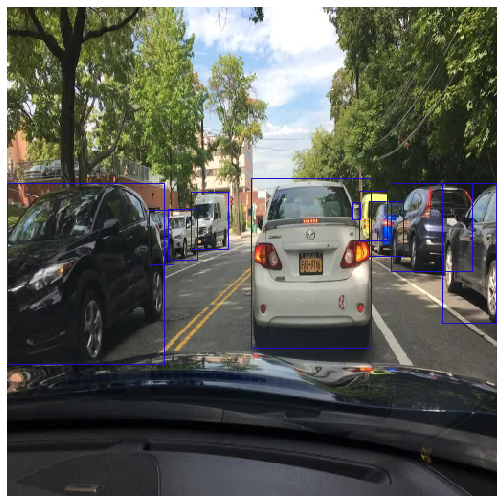

In [222]:
for x in train_dataset.take(1):
    image, label = x
image = image[0].numpy()
boxes = label[0, :, :4].numpy()
i = draw_boxes_cv2(image, boxes)
imshow(i)